
## Dynamic of spaceship controls 
Practical implementation of the ideas from this problem see [here](https://www.youtube.com/watch?v=2t15vP1PyoA)

In this problem we assume that the dynamic of spaceship controls by the Newton's second law

$$
mx''(t) = f(t) - mge_3,
$$

where $e_3$ is a vector $(0, 0, 1)$, $m$ is a mass that is constant by our assumption (otherwise we will get much complicated dynamic), $f(t)$ is a force that we can control, $x''(t)$ is acceleration.
We also skip the atmosphere affects.
This is vector equation, so $x(t)$ and $f(t)$ and 3D vectors in every timestamp. 

#### Dynamic equation we can get after discretization of the above equation

For speed we get

$$
m\frac{v_{k+1} - v_k}{h} = f_k - mge_3, \quad v_{k+1} = v_k + \frac{h}{m} f_k - hge_3
$$

and similarly for coordinates

$$
x' = v \quad x_{k+1} = x_k + \frac{h}{2}(v_k + v_{k+1})
$$

We use here Runge-Kutta method of the order 2, more details see [here](http://web.mit.edu/10.001/Web/Course_Notes/Differential_Equations_Notes/node5.html).

The landing point has coordinates $(0, 0, 0)$ and for successful landing the final speed has to be zero. 
Also, during the landing it is important to prevent shift of the spaceshift in the vertical axis, so the $z$-coordinate can not be smaller than its projection on the plane $(x, y)$ in given factor

$$
x_3(t) \geq \alpha \| (x_1(t), x_2(t)) \|_2.
$$

Since force is created my engine that consumes fuel, we have some upper bound on the force

$$
\|f(t)\|_2 \leq F_{\max}.
$$

Also the amount of the consumed fuel can be computed by the following equation

$$
\gamma \int_0^T \|f(t)\|_2 dt,
$$

 where $\gamma$ is a fuel consumption coefficient, $T$ is a landing time. 
 
During time discretization we can assume that $f(t)$ is constant in every interval $[(k-1)h; kh]$ for $k=1,\ldots,K$. Thus, the total time for landing is $Kh$. 

**Task 1**
Find the position, speed and forse in evert timestamp such that the total amount of consumed fuel is minimal

1) (2 pts) State optimization problem formally. It means define the objective function, variables and constraints explicitly in mathematical way.

2) (3 pts) Solve it with CVXPy and visualize solution 

**Task 2**
Find the minimal time that is sufficient to land the spaceship. i.e. if the time discretization step $h$ is fixed, we need to find the minimal time to move spaceship from the initial point to the final point with final speed.
You can solve multiple auxilliary problem to solve this problem.

3) (5 pts) State optimization problem formally and simplify as much as possible

4) (4 pts) Solve it with CVXPy and visualize solution. Compare the resulted trajectory with the trajectory from the task 1. How much requirement of the minimal time increased the amount of consumed fuel?

*Task 1.1*
$$
minimize \  \gamma \sum\limits_{t=1}^{K} \|f_t\|_2h
$$
$$
subject \ to \quad   x_{t+1} = x_t + \frac{h}{2}(v_t + v_{t+1}), \quad t = 1 ... K   
$$
$$
 \quad v_{t+1} = v_t + \frac{h}{m} f_t - hge_3
$$
$$
\|f_t\|_2 \leq F_{\max}
$$
$$
(x_t)_3 \geq \alpha \| ((x_t)_1, (x_t)_2) \|_2
$$
$$
x_1 = x^{init} \quad v_1 = v^{init}
$$
$$
x_K = 0 \quad v_K = 0
$$

with vairables $x$, $v$ and $f$.

*Task 1.2*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline
import cvxpy as cvx
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

# Time discretiztion step
h = 1.
# Gravity acceleration. It is just demo value to scale the solution time!
g = 0.1
# Mass
m = 10.
# Maximum norm of forse
Fmax = 10.
# Initial position
p0 = np.array([50, 50, 100])
# Initial velocity
v0 = np.array([-10, 0, -10])
# Factor of minimum slope
alpha = 0.5
# Fuel consumption factor
gamma = 1.
# Number of discretization steps, i.e. final time equals K*h
K = 36 * int(h)

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

(CVXPY) Jan 22 02:33:19 AM: Encountered unexpected exception importing solver ECOS:
ImportError('numpy.core.multiarray failed to import')


RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

(CVXPY) Jan 22 02:33:20 AM: Encountered unexpected exception importing solver ECOS_BB:
ImportError('numpy.core.multiarray failed to import')


RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

(CVXPY) Jan 22 02:33:20 AM: Encountered unexpected exception importing solver OSQP:
ImportError('numpy.core.multiarray failed to import')


In [2]:
## solution 
e3 = np.array([0,0,1])
def solveCVX(K):
    x = cvx.Variable((3,K)) # position vectors
    v = cvx.Variable((3,K)) # speed vectors
    f = cvx.Variable((3,K)) # force vectors
    
    fuel = 0
    for t in range(K): #Kh - the total time for landing
        fuel = fuel + h * cvx.norm(f[:,t], 2)
    fuelCons = gamma * fuel
    
    objective = cvx.Minimize(fuelCons)
    # Initialize
    cInit = [
        x[:,0] == p0,
        v[:,0] == v0,
    ]    
    # Target
    cTarget = [
        x[:,-1] == 0,
        v[:,-1] == 0,
    ]
    # Maximal force
    cFmax = [cvx.norm(f[:,t], 2) <= Fmax  for t in range(K)]

    # Glide cone
    cCone = [x[2,t] >= alpha * cvx.norm(x[:2,t], 2) for t in range(K)]

    # Spaceship dynamics constraints
    cVel = [v[:,t+1] == v[:,t] + h/m*f[:,t] - h*g*e3 for t in range(K-1)]
    cPos = [x[:,t+1] == x[:,t] + h/2*(v[:,t] + v[:,t+1]) for t in range(K-1)]

    constraints = cInit + cTarget + cFmax + cCone+ cVel + cPos
    # print(constraints)
    prob = cvx.Problem(objective, constraints)
    # print(prob)
    res = prob.solve(verbose=False)
    return prob.status == cvx.OPTIMAL, fuelCons.value, x, v, f


In [3]:
import math

minFuel = math.inf
minTime = None
position = None
speed = None
force = None
for t in range(1, K):
    optimal, fuelCons, pFuel, vFuel, fFuel = solveCVX(t)
    if optimal:
        if fuelCons < minFuel:
            minFuel = fuelCons
            minTime = t
            position = pFuel
            speed = vFuel
            force = fFuel
        elif fuelCons > minFuel:
          break
# print(position.shape)
# print(speed.shape)
print(f"Minimum fuel consumption: {minFuel:0.2f}, flight time: {minTime}")


Minimum fuel consumption: 193.48, flight time: 35


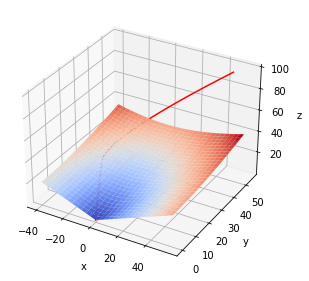

In [4]:
# use the following code to plot your trajectories
# and the glide cone
# -------------------------------------------------------
fig = plt.figure()
ax = fig.gca(projection='3d')

X = np.linspace(-40, 55, num=30)
Y = np.linspace(0, 55, num=30)
X, Y = np.meshgrid(X, Y)
Z = alpha*np.sqrt(X**2+Y**2)
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0)
#Have your solution be stored in p, which means positions
ax.plot(xs=pFuel.value[0,:],ys=pFuel.value[1,:],zs=pFuel.value[2,:], c="red")
#ax.plot(xs=pTime.value[0,:],ys=pTime.value[1,:],zs=pTime.value[2,:], c="blue")
ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('z')
plt.tight_layout()

*Task 2.1* State optimization problem formally and simplify as much as possible, 

since $\gamma = 1$ and $h = 1$ 
$$
minimize \  t, \quad t = 1 ... K 
$$

or it can be simplified, such that, finding the time until fuel is in feasible region, which means objective function is 0

$$
minimize \  0
$$

$$
subject \ to \quad   x_{t+1} = x_t + \frac{(v_t + v_{t+1})}{2}, \quad t = 1 ... K   
$$

$$
 \quad v_{t+1} = v_t + \frac{f_t}{m}  - ge_3
$$
$$
\|f_t\|_2 \leq F_{\max}
$$
$$
(x_t)_3 \geq \alpha \| ((x_t)_1, (x_t)_2) \|_2
$$
$$
x_1 = x^{init} \quad v_1 = v^{init}
$$
$$
x_K = 0 \quad v_K = 0
$$

with vairables $x$, $v$ and $f$.

*Task 2*

In [5]:
## Your solution is here
e3 = np.array([0,0,1])
def solveCVX_time(K):
    x = cvx.Variable((3,K)) # position vectors
    v = cvx.Variable((3,K)) # speed vectors
    f = cvx.Variable((3,K)) # force vectors
    
    fuel = 0
    for t in range(K): #Kh - the total time for landing
        fuel = fuel + h * cvx.norm(f[:,t], 2)
    fuelCons = gamma * fuel
    #objective = cvx.Minimize(K)
    objective = cvx.Minimize(0)
    # Initialize
    cInit = [
        x[:,0] == p0,
        v[:,0] == v0,
    ]    
    # Target
    cTarget = [
        x[:,-1] == 0,
        v[:,-1] == 0,
    ]
    # Maximal force
    cFmax = [cvx.norm(f[:,t], 2) <= Fmax  for t in range(K)]

    # Glide cone
    cCone = [x[2,t] >= alpha * cvx.norm(x[:2,t], 2) for t in range(K)]

    # Spaceship dynamics constraints
    cVel = [v[:,t+1] == v[:,t] + h/m*f[:,t] - h*g*e3 for t in range(K-1)]
    cPos = [x[:,t+1] == x[:,t] + h/2*(v[:,t] + v[:,t+1]) for t in range(K-1)]

    constraints = cInit + cTarget + cFmax + cCone+ cVel + cPos
    # print(constraints)
    prob = cvx.Problem(objective, constraints)
    # print(prob)
    res = prob.solve(verbose=False)
    return prob.status == cvx.OPTIMAL, fuelCons.value, x, v, f



In [6]:
#task 2 Find the minimal time that is sufficient to land the spaceship
minFlightTime = None
for t in range(1, K):
    optimal, fuelCons_byTime, pTime, vFuel, fFuel  = solveCVX_time(t)
    if optimal:
        minFlightTime = t
        break

print(f"the minimal time that is sufficient to land the spaceship: {minFlightTime}, fuel consumption: {fuelCons_byTime:0.2f}")

the minimal time that is sufficient to land the spaceship: 26, fuel consumption: 250.00


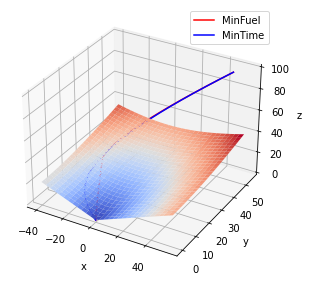

In [7]:
fig = plt.figure()
ax = fig.gca(projection='3d')

X = np.linspace(-40, 55, num=30)
Y = np.linspace(0, 55, num=30)
X, Y = np.meshgrid(X, Y)
Z = alpha*np.sqrt(X**2+Y**2)
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.coolwarm, linewidth=0)
#Have your solution be stored in p, which means positions
line1,= ax.plot(xs=pFuel.value[0,:],ys=pFuel.value[1,:],zs=pFuel.value[2,:], c="red", label='MinFuel')
line2,= ax.plot(xs=pTime.value[0,:],ys=pTime.value[1,:],zs=pTime.value[2,:], c="blue", label='MinTime')
ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('z')
ax.legend(handles=[line1, line2])
plt.tight_layout()

In [8]:
difference = fuelCons_byTime - fuelCons
print(f"How much requirement of the minimal time increased the amount of consumed fuel, answer is: {difference:0.2f}")

How much requirement of the minimal time increased the amount of consumed fuel, answer is: 56.52
